In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#from tensorflow.keras import layers
#from tensorflow.keras import regularizers
import keras_tuner as kt

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
#from sklearn.preprocessing import OneHotEncoder


tf.__version__

2023-05-26 12:07:04.062077: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 12:07:04.181428: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-26 12:07:04.605405: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-26 12:07:04.605448: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

'2.11.0'

In [2]:
# Load dataset
csv_file = '../Dataset/dataset.csv'
#csv_file = '../Dataset/dataset_augmented.csv'
#csv_file = '../Dataset/dataset_left.csv'
dataframe_raw = pd.read_csv(csv_file)
dataframe_raw = dataframe_raw.drop(dataframe_raw.columns[0],axis=1) # remove first column (no information there)
dataframe_raw.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,Nsubs,R,lambd
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,2,484.4822,350.23
1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,2,774.6917,347.50
2,0,0,0,0,0,0,0,2,1,0,0,0,0,0,3,3,4,644.6140,364.11
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,2,630.3364,347.10
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,4,392.8587,358.78


In [3]:
dataframe = dataframe_raw.copy()

# Create a target variable
dataframe['target'] = dataframe['R']

# Create array with number of subtitutes
nsubs = []
nsubs[:] = dataframe['Nsubs']

# Drop unused features.
dataframe = dataframe.drop(columns=['R', 'lambd', 'Nsubs'])
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,target
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,484.4822
1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,774.6917
2,0,0,0,0,0,0,0,2,1,0,0,0,0,0,3,3,644.6140
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,630.3364
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,392.8587


1
32
140
83
77


Text(0, 0.5, 'count')

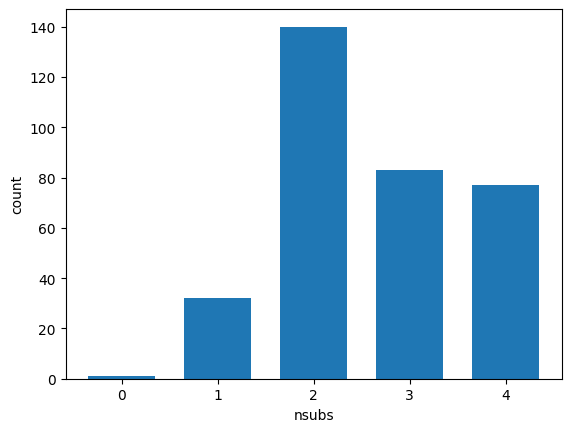

In [4]:
# number of substitutes

n0 = nsubs.count(0)
n1 = nsubs.count(1)
n2 = nsubs.count(2)
n3 = nsubs.count(3)
n4 = nsubs.count(4)
print(n0)
print(n1)
print(n2)
print(n3)
print(n4)

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist(nsubs, bins=bin_edges, rwidth=0.7)
plt.xlabel('nsubs')
plt.ylabel('count')

In [5]:
# Check overal statistis of each input feature 
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,333.0,0.345345,0.936678,0.0000,0.0000,0.0000,0.0000,4.0000
Pos2,333.0,0.444444,1.081362,0.0000,0.0000,0.0000,0.0000,4.0000
Pos3,333.0,0.369369,0.978023,0.0000,0.0000,0.0000,0.0000,4.0000
Pos4,333.0,0.426426,1.040516,0.0000,0.0000,0.0000,0.0000,4.0000
Pos5,333.0,0.429429,1.037826,0.0000,0.0000,0.0000,0.0000,4.0000
Pos6,333.0,0.363363,0.961664,0.0000,0.0000,0.0000,0.0000,4.0000
Pos7,333.0,0.366366,0.955806,0.0000,0.0000,0.0000,0.0000,4.0000
Pos8,333.0,0.450450,1.084436,0.0000,0.0000,0.0000,0.0000,4.0000
Pos9,333.0,0.483483,1.104699,0.0000,0.0000,0.0000,0.0000,4.0000
Pos10,333.0,0.435435,1.075272,0.0000,0.0000,0.0000,0.0000,4.0000


/tmp/ipykernel_125714/2418938743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe[['target']])


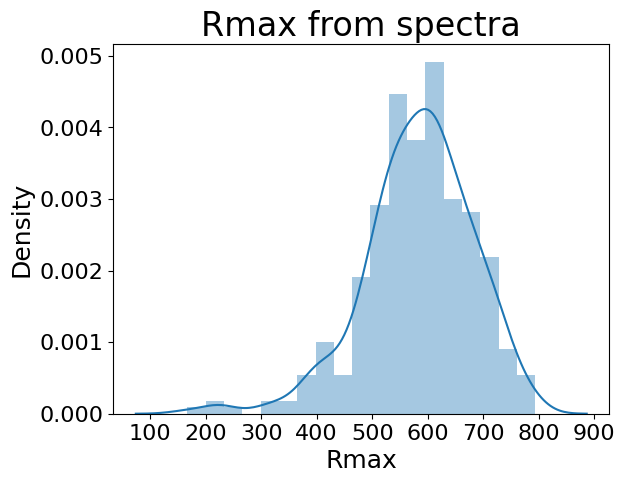

In [6]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set

#sns.pairplot(dataframe[['target']], diag_kind='kde')
#sns.set_style('darkgrid')
sns.distplot(dataframe[['target']])
plt.title('Rmax from spectra',fontsize=24)
plt.xlabel('Rmax',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Text(0, 0.5, 'Rmax')

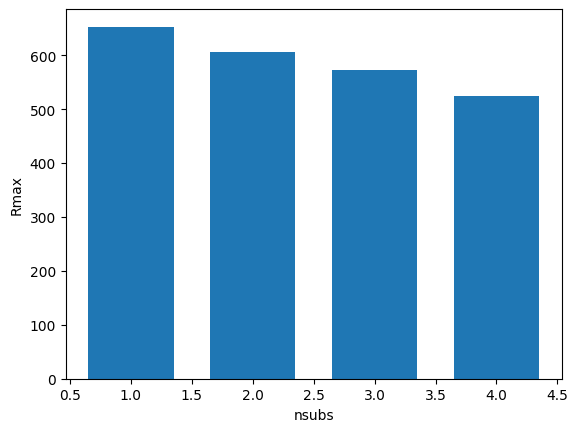

In [7]:
# Rmax as a function of nsubs
Rmax = []
Rmax[:] = dataframe['target']

nsubs1 = [i for i in range(len(nsubs)) if nsubs[i]==1]
nsubs2 = [i for i in range(len(nsubs)) if nsubs[i]==2]
nsubs3 = [i for i in range(len(nsubs)) if nsubs[i]==3]
nsubs4 = [i for i in range(len(nsubs)) if nsubs[i]==4]

Rmax1 = [Rmax[i] for i in nsubs1]
Rmax2 = [Rmax[i] for i in nsubs2]
Rmax3 = [Rmax[i] for i in nsubs3]
Rmax4 = [Rmax[i] for i in nsubs4]

Rmax1_mean = np.mean(Rmax1)
Rmax2_mean = np.mean(Rmax2)
Rmax3_mean = np.mean(Rmax3)
Rmax4_mean = np.mean(Rmax4)

Rmax_mean = [Rmax1_mean, Rmax2_mean, Rmax3_mean, Rmax4_mean]

bin_edges = np.arange(1.5,4.5+1,1)
plt.bar([1,2,3,4],Rmax_mean, width=0.7)
plt.xlabel('nsubs')
plt.ylabel('Rmax')


In [8]:
# remove data with R~8

dataframe = dataframe[ dataframe['target']>10 ]
dataframe.describe().transpose()

# remove data with target<Rmin
Rmin = 380
dataframe = dataframe[ dataframe['target']>Rmin ]
print(dataframe.describe().transpose())

        count        mean        std       min         25%        50%  \
Pos1    324.0    0.333333   0.931060    0.0000    0.000000    0.00000   
Pos2    324.0    0.416667   1.039096    0.0000    0.000000    0.00000   
Pos3    324.0    0.351852   0.953872    0.0000    0.000000    0.00000   
Pos4    324.0    0.404321   1.004686    0.0000    0.000000    0.00000   
Pos5    324.0    0.429012   1.031046    0.0000    0.000000    0.00000   
Pos6    324.0    0.361111   0.952022    0.0000    0.000000    0.00000   
Pos7    324.0    0.376543   0.967045    0.0000    0.000000    0.00000   
Pos8    324.0    0.453704   1.087938    0.0000    0.000000    0.00000   
Pos9    324.0    0.490741   1.114181    0.0000    0.000000    0.00000   
Pos10   324.0    0.435185   1.069763    0.0000    0.000000    0.00000   
Pos11   324.0    0.364198   0.968585    0.0000    0.000000    0.00000   
Pos12   324.0    0.398148   1.031454    0.0000    0.000000    0.00000   
Pos13   324.0    0.256173   0.821042    0.0000    0

In [9]:
# normalize numerical targets

R_mean = dataframe['target'].mean()
R_std = dataframe['target'].std()

dataset = dataframe.copy()

dataset['target']=(dataset['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,324.0,3.333333e-01,0.931060,0.000000,0.000000,0.00000,0.00000,4.000000
Pos2,324.0,4.166667e-01,1.039096,0.000000,0.000000,0.00000,0.00000,4.000000
Pos3,324.0,3.518519e-01,0.953872,0.000000,0.000000,0.00000,0.00000,4.000000
Pos4,324.0,4.043210e-01,1.004686,0.000000,0.000000,0.00000,0.00000,4.000000
Pos5,324.0,4.290123e-01,1.031046,0.000000,0.000000,0.00000,0.00000,4.000000
Pos6,324.0,3.611111e-01,0.952022,0.000000,0.000000,0.00000,0.00000,4.000000
Pos7,324.0,3.765432e-01,0.967045,0.000000,0.000000,0.00000,0.00000,4.000000
Pos8,324.0,4.537037e-01,1.087938,0.000000,0.000000,0.00000,0.00000,4.000000
Pos9,324.0,4.907407e-01,1.114181,0.000000,0.000000,0.00000,0.00000,4.000000
Pos10,324.0,4.351852e-01,1.069763,0.000000,0.000000,0.00000,0.00000,4.000000


In [10]:
# One-hot encode inpute features manually 
n_data = dataset.shape[0]
n_atom_types = 5   # (H,Fl,Cl,Br,I)
n_pos = 16         # 6-helicenes have 16 possible positions to be occupied
n_features = int(n_atom_types*n_pos)
x_data = np.zeros( (n_data, n_features) )
y_data = np.zeros(n_data)

n_labels = 1
data = np.zeros( (n_data, n_features+n_labels) )

dataset_np = dataset.to_numpy()
#print(dataset_np.shape)
for i in range(n_data):
    for j in range(n_pos):
        atom_id = int(dataset_np[i,j])
        x_data[i,j*n_atom_types+atom_id] = 1.0

    #print(x_data[i,:])
    #print(dataset_np[i,:16])

    y_data[i] = dataset_np[i,n_pos]

    data[i,0:n_features] = x_data[i,:] 
    data[i,n_features] = y_data[i]

print(x_data.shape)
print(y_data.shape)
print(data.shape)


(324, 80)
(324,)
(324, 81)


In [11]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#x_data = data[:,0:n_features]
#y_data = data[:,n_features]
data = shuffle(data, random_state=39)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

print(len(x_train), 'training examples')
print(len(x_test), 'test and validation examples')
print(x_train.shape)
print(y_train.shape)

259 training examples
65 test and validation examples
(259, 80)
(259,)


In [12]:
""" # non-linear model with multiple inputs

# First, define a single model for a single position
def single_model():
    inputs = tf.keras.Input( shape=(n_atom_types,) )
    outputs = tf.keras.layers.Dense(1,use_bias=False)(inputs)
    return tf.keras.Model(inputs,outputs)

# save into a list 8 models
linear_models = []
for i in range(int(n_pos/2)):
    model_i = single_model()
    linear_models.append(model_i)

# save into a list inputs for different positions
inputs = []
for i in range(n_pos):
    input_i = tf.keras.Input( shape=(n_atom_types,), name='Pos_'+str(i+1) )
    inputs.append( input_i ) 
    #input_i = tf.keras.Input(shape=(n_atom_types,name="Pos_i"))
    #input_i = tf.keras.Input( shape=(n_atom_types,), name='Pos_i' )
print(inputs)

linear_outputs = []
# save into a list linear outputs for positions 1-8
for i in range(int(n_pos/2)):
    output_i = linear_models[i]( inputs[i] )
    linear_outputs.append( output_i )

# save into a list linear outputs for positions 9-16
for i in range(int(n_pos/2),n_pos):
    output_i = linear_models[n_pos-1-i]( inputs[i] )
    linear_outputs.append( output_i )    

print(linear_outputs)

#global_output = tf.keras.layers.Add(name='SUM')(linear_outputs)
x = tf.keras.layers.Concatenate()(linear_outputs)

#x = tf.keras.layers.Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
#x = tf.keras.layers.Dropout(0.5)(x)

#x = tf.keras.layers.Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
#
# x = tf.keras.layers.Dropout(0.5)(x)
""" x = tf.keras.layers.Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Dropout(0.25)(x) """
#x = tf.keras.layers.Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
#x = tf.keras.layers.Dropout(0.25)(x)
""" x = tf.keras.layers.Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
x = tf.keras.layers.Dropout(0.25)(x) """
global_output = tf.keras.layers.Dense(1)(x)
print(global_output)

model = tf.keras.Model(inputs=inputs,outputs=global_output)
model.summary()
tf.keras.utils.plot_model(model, "non-linear_many-body_invariant_model.png", show_shapes=True)

learning_rate = 0.01
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error') """

[<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_1')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_2')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_3')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_4')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_5')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_6')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_7')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_8')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_9')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_10')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_11')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_12')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_13')>, <KerasTensor: shape=(None, 5) dtype=float32 (c

2023-05-26 06:24:55.786892: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-26 06:24:55.849893: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-05-26 06:24:55.849918: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-26 06:24:55.850598: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

In [116]:
# non-linear model with multiple inputs

# Define the hypermodel to optimize hyperparameters

def model_builder(hp):

    # First, define a single model for a single position
    def single_model():
        inputs = tf.keras.Input( shape=(n_atom_types,) )
        outputs = tf.keras.layers.Dense(1)(inputs)
        return tf.keras.Model(inputs,outputs)

    # save into a list 8 models
    linear_models = []
    for i in range(int(n_pos/2)):
        model_i = single_model()
        linear_models.append(model_i)

    # save into a list inputs for different positions
    inputs = []
    for i in range(n_pos):
        input_i = tf.keras.Input( shape=(n_atom_types,), name='Pos_'+str(i+1) )
        inputs.append( input_i ) 
        #input_i = tf.keras.Input(shape=(n_atom_types,name="Pos_i"))
        #input_i = tf.keras.Input( shape=(n_atom_types,), name='Pos_i' )
    print(inputs)

    linear_outputs = []
    # save into a list linear outputs for positions 1-8
    for i in range(int(n_pos/2)):
        output_i = linear_models[i]( inputs[i] )
        linear_outputs.append( output_i )

    # save into a list linear outputs for positions 9-16
    for i in range(int(n_pos/2),n_pos):
        output_i = linear_models[n_pos-1-i]( inputs[i] )
        linear_outputs.append( output_i )    

    linear_outputs_rev = []
    for i in range(n_pos):
        linear_outputs_rev.append( linear_outputs[n_pos-i-1] ) 

    x = tf.keras.layers.Concatenate()(linear_outputs)
    x_rev = tf.keras.layers.Concatenate()(linear_outputs_rev)

    # Tune the number of units in the Dense layers
    # Choose an optimal value between 8-128
    hp_units = hp.Int('units', min_value=8, max_value=512, step=2, sampling='log')

    # Tune the number of layers between 1-4
    #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1, sampling='linear')
    hp_layers = hp.Int('layers', min_value=1, max_value=4, step=2, sampling='log')

    # Tune activation function between relu, tanh and sigmoid
    #hp_activation = hp.Choice('activation', values=['relu','tanh','sigmoid'])
    hp_activation = hp.Choice('activation', values=['relu','tanh']) 

    # Define a single non-linear model
    def NN_model():
        inputs = tf.keras.Input( shape=(n_pos,) )
        # Define architecture    
        output = inputs
        for i in range(hp_layers):
            output = tf.keras.layers.Dense(units=hp_units, activation=hp_activation)(output)
            output = tf.keras.layers.Dropout(0.5)(output)
        output = tf.keras.layers.Dense(1)(output)
        return tf.keras.Model(inputs,output)

    non_linear_model = NN_model()    

    output1 = non_linear_model(x)
    output2 = non_linear_model(x_rev)

    NN_outputs = []
    NN_outputs.append(output1)
    NN_outputs.append(output2)
    global_output = tf.keras.layers.Add(name='SUM')(NN_outputs)

    model = tf.keras.Model(inputs=inputs,outputs=global_output)
    model.summary()
    #tf.keras.utils.plot_model(model, "non-linear_many-body_invariant_model.png", show_shapes=True)

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])    

    #learning_rate = 0.01
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='mean_absolute_error')
    
    return model

In [117]:
# Instantiate the tuner and perform hypertuning

tuner = kt.Hyperband(model_builder,
                     #objective='val_accuracy',
                     objective='val_loss',
                     #max_epochs=10,
                     max_epochs=20,
                     factor=3,
                     #factor=2,
                     directory='./Hypertuning',
                     project_name='hypertuning_manybody_def')

[<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_1')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_2')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_3')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_4')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_5')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_6')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_7')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_8')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_9')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_10')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_11')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_12')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_13')>, <KerasTensor: shape=(None, 5) dtype=float32 (c

In [119]:
# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# search() method receives same arguments as fit() method, plus callbacks
# if batch_size is not specified, 32 is the default value
batch_size = 4
train_inputs = np.split(x_train,n_pos,axis=1)
#tuner.search(x=train_inputs, y=y_train, epochs=200, validation_split=0.2, batch_size=128, callbacks=[stop_early])
tuner.search(x=train_inputs, y=y_train, epochs=200, validation_split=0.2, batch_size=batch_size, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: {best_hps.get('layers')}
n_units: {best_hps.get('units')}
learning_rate: {best_hps.get('learning_rate')}
activation_function: {best_hps.get('activation')}
""")

Trial 30 Complete [00h 00m 05s]
val_loss: 0.7278590798377991

Best val_loss So Far: 0.3069591522216797
Total elapsed time: 00h 01m 35s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: 1
n_units: 16
learning_rate: 0.01
activation_function: tanh



In [12]:
# Single non-linear model with multiple inputs

# Define the hypermodel to optimize hyperparameters

# First, define a single model for a single position
def single_model():
    inputs = tf.keras.Input( shape=(n_atom_types,) )
    outputs = tf.keras.layers.Dense(1,use_bias=False,kernel_initializer='random_normal')(inputs)
    return tf.keras.Model(inputs,outputs)

""" # save into a list 8 models
linear_models = []
for i in range(int(n_pos/2)):
    model_i = single_model()
    linear_models.append(model_i) """
# save into a list 16 models
linear_models = []
for i in range(n_pos):
    model_i = single_model()
    linear_models.append(model_i)

# save into a list inputs for different positions
inputs = []
for i in range(n_pos):
    input_i = tf.keras.Input( shape=(n_atom_types,), name='Pos_'+str(i+1) )
    inputs.append( input_i ) 
    #input_i = tf.keras.Input(shape=(n_atom_types,name="Pos_i"))
    #input_i = tf.keras.Input( shape=(n_atom_types,), name='Pos_i' )
print(inputs)

""" linear_outputs = []
# save into a list linear outputs for positions 1-8
for i in range(int(n_pos/2)):
    output_i = linear_models[i]( inputs[i] )
    linear_outputs.append( output_i )

# save into a list linear outputs for positions 9-16
for i in range(int(n_pos/2),n_pos):
    output_i = linear_models[n_pos-1-i]( inputs[i] )
    linear_outputs.append( output_i )     """
# save into a list linear outputs for positions 1-16
linear_outputs = []
for i in range(n_pos):
    output_i = linear_models[i]( inputs[i] )
    linear_outputs.append( output_i )

""" linear_outputs = []
#linear_models = []
# save into a list linear outputs and models for positions 1-8
for i in range(n_pos/2):
    #output_i = tf.keras.layers.Dense(1,name='W_'+str(i+1))(inputs[i])
    #linear_outputs.append( output_i )
    #model_i = tf.keras.Model(inputs=inputs[i],outputs=output_i)
    #linear_models.append( model_i )
    output_i = linear_models[i]( inputs[i] )

# save into a list linear outputs and models for positions 9-16
for i in range(n_pos/2,n_pos):
    #output_i = tf.keras.layers.Dense(1,name='W_'+str(i+1))(inputs[i])
    output_i = linear_outputs[n_pos-1-i] # model for Pos 16 (index 15) is equal to model por Pos 1 (index 0)
    linear_outputs.append( output_i )
    #model_i = tf.keras.Model(inputs=inputs[i],outputs=output_i)
    model_i = linear_models[]
    linear_models.append( model_i )     """

print(linear_outputs)
#x = tf.keras.layers.Concatenate()(linear_outputs)
#print(x)
#x_rev = tf.reverse(x,axis=0)
#print(x_rev)

linear_outputs_rev = []
for i in range(n_pos):
    linear_outputs_rev.append( linear_outputs[n_pos-i-1] )   
print(linear_outputs_rev)

x = tf.keras.layers.Concatenate()(linear_outputs)
x_rev = tf.keras.layers.Concatenate()(linear_outputs_rev) 

""" x = tf.keras.layers.Dense(units=256, activation='relu')(x)        
x = tf.keras.layers.Dropout(0.5)(x)
x_rev = tf.keras.layers.Dense(units=256, activation='relu')(x_rev)        
x_rev = tf.keras.layers.Dropout(0.5)(x_rev) """

""" output1 = tf.keras.layers.Dense(units=256, activation='relu')(x)        
output1 = tf.keras.layers.Dropout(0.5)(output1)
output1 = tf.keras.layers.Dense(1)(output1)
output2 = tf.keras.layers.Dense(units=256, activation='relu')(x_rev)        
output2 = tf.keras.layers.Dropout(0.5)(output2)
output2 = tf.keras.layers.Dense(1)(output2) """

# Define a single non-linear model
def NN_model():
    inputs = tf.keras.Input( shape=(n_pos,) )
    output = tf.keras.layers.Dense(units=256, activation='relu',kernel_initializer='random_normal',bias_initializer='zeros')(inputs)
    output = tf.keras.layers.Dropout(0.5)(output)

    """ output = tf.keras.layers.Dense(units=256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(inputs)
    output = tf.keras.layers.Dropout(0.5)(output)
    output = tf.keras.layers.Dense(units=256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(output)
    output = tf.keras.layers.Dropout(0.5)(output) """
    #output = tf.keras.layers.Dense(units=128, activation='relu')(inputs)
    #output = tf.keras.layers.Dropout(0.5)(output)
    #output = tf.keras.layers.Dense(units=128, activation='relu')(output)
    #output = tf.keras.layers.Dropout(0.5)(output)

    output = tf.keras.layers.Dense(1)(output)
    return tf.keras.Model(inputs,output)

non_linear_model = NN_model()

#print('x')
#print(x)
#print('x_rev')
#print(x_rev)
#output1 = NN_model(x)
#output2 = NN_model(x_rev)
output1 = non_linear_model(x)
output2 = non_linear_model(x_rev)

NN_outputs = []
NN_outputs.append(output1)
NN_outputs.append(output2)
global_output = tf.keras.layers.Add(name='SUM')(NN_outputs)
#global_output = tf.keras.layers.Add(name='SUM')(linear_outputs)
print(global_output)

model = tf.keras.Model(inputs=inputs,outputs=global_output)
model.summary()
tf.keras.utils.plot_model(model, "linear_invariant_model.png", show_shapes=True)

learning_rate = 0.01
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error')

[<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_1')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_2')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_3')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_4')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_5')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_6')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_7')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_8')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_9')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_10')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_11')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_12')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'Pos_13')>, <KerasTensor: shape=(None, 5) dtype=float32 (c

2023-05-26 12:08:27.134867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-26 12:08:27.158051: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-05-26 12:08:27.158077: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-26 12:08:27.158636: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

In [13]:
# Train single model

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-6)

epochs = 200
batch_size = 4

# split input into 16 positions
train_inputs = np.split(x_train,n_pos,axis=1)
print(len(train_inputs))
#history = model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)
#model = tuner.hypermodel.build(best_hps)
tf.keras.utils.plot_model(model, "non-linear_many-body_invariant_model.png", show_shapes=True)
history = model.fit(x=train_inputs, y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)


16
Epoch 1/200
59/59 - 1s - loss: 0.8666 - val_loss: 0.7898 - lr: 0.0100 - 1s/epoch - 19ms/step
Epoch 2/200
59/59 - 0s - loss: 0.7957 - val_loss: 0.7752 - lr: 0.0100 - 89ms/epoch - 2ms/step
Epoch 3/200
59/59 - 0s - loss: 0.7435 - val_loss: 0.6156 - lr: 0.0100 - 90ms/epoch - 2ms/step
Epoch 4/200
59/59 - 0s - loss: 0.6466 - val_loss: 0.9204 - lr: 0.0100 - 98ms/epoch - 2ms/step
Epoch 5/200
59/59 - 0s - loss: 0.6478 - val_loss: 0.5312 - lr: 0.0100 - 92ms/epoch - 2ms/step
Epoch 6/200
59/59 - 0s - loss: 0.5719 - val_loss: 0.4668 - lr: 0.0100 - 101ms/epoch - 2ms/step
Epoch 7/200
59/59 - 0s - loss: 0.4826 - val_loss: 0.4824 - lr: 0.0100 - 96ms/epoch - 2ms/step
Epoch 8/200
59/59 - 0s - loss: 0.4629 - val_loss: 0.4920 - lr: 0.0100 - 112ms/epoch - 2ms/step
Epoch 9/200
59/59 - 0s - loss: 0.5147 - val_loss: 0.4163 - lr: 0.0100 - 112ms/epoch - 2ms/step
Epoch 10/200
59/59 - 0s - loss: 0.4623 - val_loss: 0.3608 - lr: 0.0100 - 113ms/epoch - 2ms/step
Epoch 11/200
59/59 - 0s - loss: 0.4054 - val_loss: 0.

In [22]:
# Train the model with optimal hyperparameters

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-6)

epochs = 200
#batch_size = 4

# split input into 16 positions
train_inputs = np.split(x_train,n_pos,axis=1)
print(len(train_inputs))
#history = model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)
model = tuner.hypermodel.build(best_hps)
tf.keras.utils.plot_model(model, "non-linear_many-body_invariant_model.png", show_shapes=True)
history = model.fit(x=train_inputs, y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)


16


NameError: name 'tuner' is not defined

Best epoch: 48


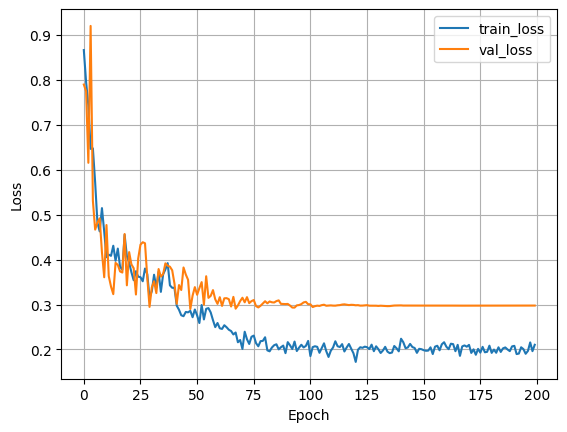

In [14]:
# Plot the loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [15]:
def plot_PredvsTrue(y_true, y_pred):

    plt.figure(figsize=(3, 3), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
    plt.scatter(y_true,y_pred,color="blue",label="Model",s=6)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

3/3 [==============================] - 0s 2ms/step
(65, 1)
(65, 1)


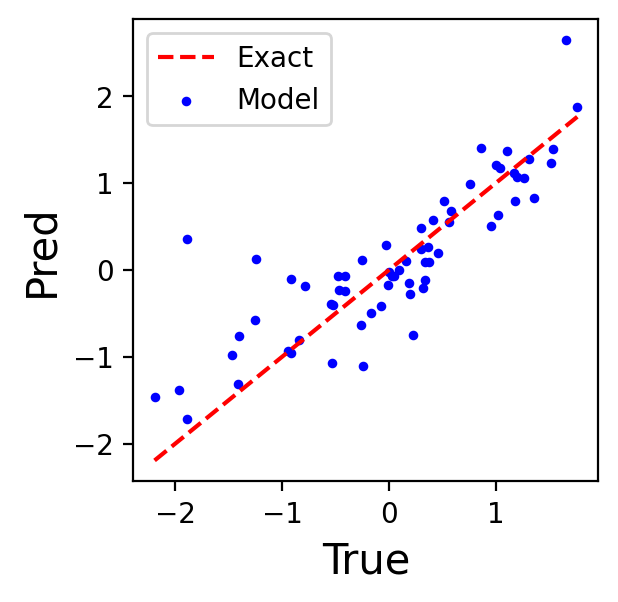

Test MAE: 0.35551148050057124
Test MSE: 0.2554814914195702


In [16]:
# Pred vs True values on test set 

#y_pred = model.predict(x_test)
test_inputs = np.split(x_test,n_pos,axis=1)
y_pred = model.predict(test_inputs)
y_pred.shape
y_true = np.zeros((len(y_test),1))
y_true[:,0] = y_test[:]

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
test_mse = mean_squared_error(y_true,y_pred)

print("Test MAE: "+str(test_mae))
print("Test MSE: "+str(test_mse))

In [18]:
# save model

#reloaded_model = tf.keras.models.load_model('R_model')
model.save('./Models/R_model_invariant_non-linear_many-body_dropout_def_test')

INFO:tensorflow:Assets written to: ./Models/R_model_invariant_non-linear_many-body_dropout_def_test/assets


INFO:tensorflow:Assets written to: ./Models/R_model_invariant_non-linear_many-body_dropout_def_test/assets


9/9 [==============================] - 0s 1ms/step


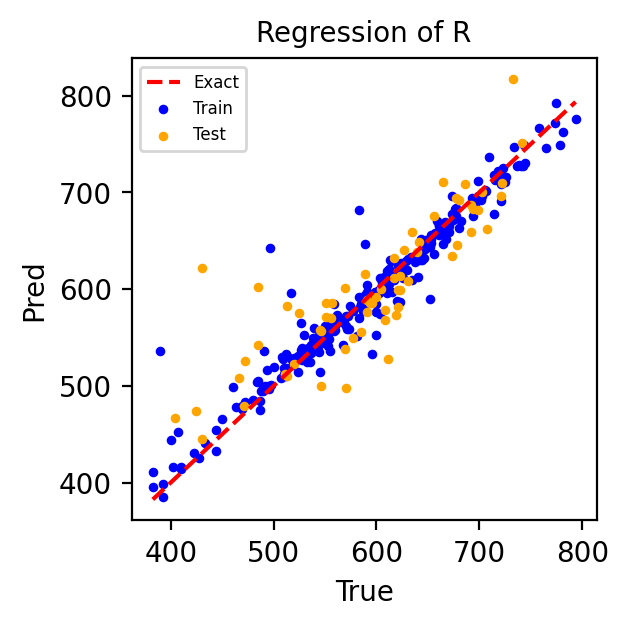

Train MAE (non-normalized): 11.776563821187258
Train RMSE (non-normalized): 20.950454895852108
Train MAPE (non-normalized): 2.1227556109600227
Train R2 (non-normalized): 0.9408333500045224

Test MAE (non-normalized): 30.354275559645437
Test RMSE (non-normalized): 43.15648208713474
Test MAPE (non-normalized): 5.512929908224399
Test R2 (non-normalized): 0.719854525316719


In [17]:
# Evaluate the model with non-normalized units on the whole dataset

#y_pred_test = model.predict(x_test)
y_pred_test = model.predict(test_inputs)
y_true_test = np.zeros((len(y_test),1))
y_true_test[:,0] = y_test[:]

#y_pred_train = model.predict(x_train)
y_pred_train = model.predict(train_inputs)
y_true_train = np.zeros((len(y_train),1))
y_true_train[:,0] = y_train[:]

y_true_test = y_true_test * R_std + R_mean
y_pred_test = y_pred_test * R_std + R_mean
y_true_test = y_true_test.ravel()
y_pred_test = y_pred_test.ravel()

y_true_train = y_true_train * R_std + R_mean
y_pred_train = y_pred_train * R_std + R_mean
y_true_train = y_true_train.ravel()
y_pred_train = y_pred_train.ravel()

#y_true_val = y_true_val * R_std + R_mean
#y_pred_val = y_pred_val * R_std + R_mean
#y_true_val = y_true_val.ravel()
#y_pred_val = y_pred_val.ravel()

plt.figure(figsize=(3, 3), dpi=200)
plt.title("Regression of R",fontsize=10)
p1 = min(y_true_train)
p2 = max(y_true_train)
plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
plt.scatter(y_true_train,y_pred_train,color="blue",label="Train",s=6)
plt.scatter(y_true_test,y_pred_test,color="orange",label="Test",s=6)
#plt.scatter(y_true_val,y_pred_val,color="green",label="Val",s=6)
plt.xlabel('True',fontsize=10)
plt.ylabel('Pred',fontsize=10)
plt.legend(loc="upper left",prop={'size': 6})
plt.show()

train_mae = mean_absolute_error(y_true_train,y_pred_train)
print("Train MAE (non-normalized): "+str(train_mae))
train_mse = mean_squared_error(y_true_train,y_pred_train,squared=False)
print("Train RMSE (non-normalized): "+str(train_mse))
train_mape = mean_absolute_percentage_error(y_true_train,y_pred_train)*100
print("Train MAPE (non-normalized): "+str(train_mape))
train_r2 = r2_score(y_true_train,y_pred_train)
print("Train R2 (non-normalized): "+str(train_r2))

print()
test_mae = mean_absolute_error(y_true_test,y_pred_test)
print("Test MAE (non-normalized): "+str(test_mae))
test_mse = mean_squared_error(y_true_test,y_pred_test,squared=False)
print("Test RMSE (non-normalized): "+str(test_mse))
test_mape = mean_absolute_percentage_error(y_true_test,y_pred_test)*100
print("Test MAPE (non-normalized): "+str(test_mape))
test_r2 = r2_score(y_true_test,y_pred_test)
print("Test R2 (non-normalized): "+str(test_r2))

#val_mae = mean_absolute_error(y_true_val,y_pred_val)
#print("val MAE (non-normalized): "+str(val_mae))

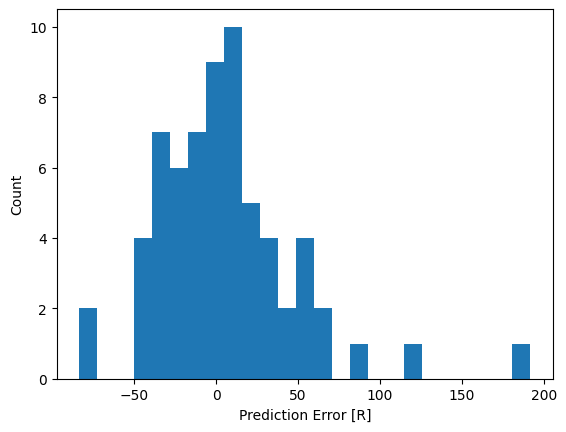

In [18]:
# Error distribution
error = y_pred_test - y_true_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [R]')
_ = plt.ylabel('Count')


[ 0.  4. 30. 17. 14.]
[        nan 15.16538369 28.99901719 30.37623363 37.57142067]


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


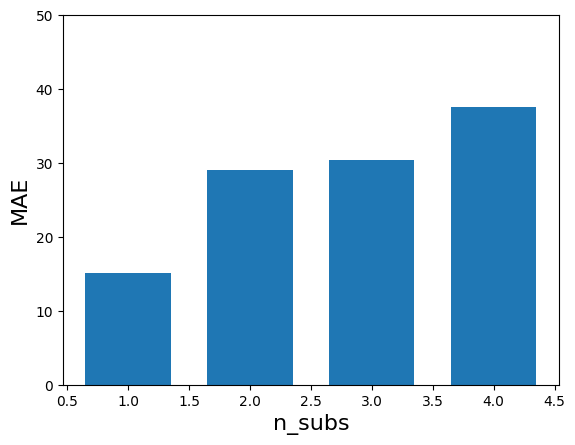

In [19]:
# Error for different nsubs

#x_test = test_features.to_numpy()

nsubs_test = np.zeros( x_test.shape[0] )
#print(x_test[0,:])

# compute number of substitutes for each data test
for i in range(len(nsubs_test)):

    # for each data, check if first input of every position is an hydrogen
    nsubs_i = 0
    for j in range(n_pos):
        if( x_test[i,j*n_atom_types]==0.0 ): # no hydrogen, hence there is a different substitute
            nsubs_i = nsubs_i+1
    nsubs_test[i] = nsubs_i
#print(nsubs_test)

error0 = []
error1 = []
error2 = []
error3 = []
error4 = []
num_subs = np.zeros(5)
for i in range(len(nsubs_test)):
    error_i = y_pred_test[i] - y_true_test[i]
    if(nsubs_test[i]==0): 
        error0.append(error_i)
        num_subs[0] +=1
    if(nsubs_test[i]==1): 
        error1.append(error_i)
        num_subs[1] +=1
    if(nsubs_test[i]==2): 
        error2.append(error_i)
        num_subs[2] +=1
    if(nsubs_test[i]==3): 
        error3.append(error_i)
        num_subs[3] +=1
    if(nsubs_test[i]==4): 
        error4.append(error_i)
        num_subs[4] +=1

error_nsubs = np.zeros(5)
error_nsubs[0] = np.mean(np.abs(error0))
error_nsubs[1] = np.mean(np.abs(error1))
error_nsubs[2] = np.mean(np.abs(error2))
error_nsubs[3] = np.mean(np.abs(error3))
error_nsubs[4] = np.mean(np.abs(error4))

print(num_subs)
print(error_nsubs)

bin_edges = np.arange(1.5,4.5+1,1)
plt.bar([0,1,2,3,4],error_nsubs[0:], width=0.7)
plt.xlabel("n_subs",fontsize=16)
plt.ylabel("MAE",fontsize=16)
plt.ylim((0,50))
plt.show()

[  1.  28. 109.  63.  58.]
[ 4.29259248  8.42344788 11.89834776 17.47173586 12.84092204]


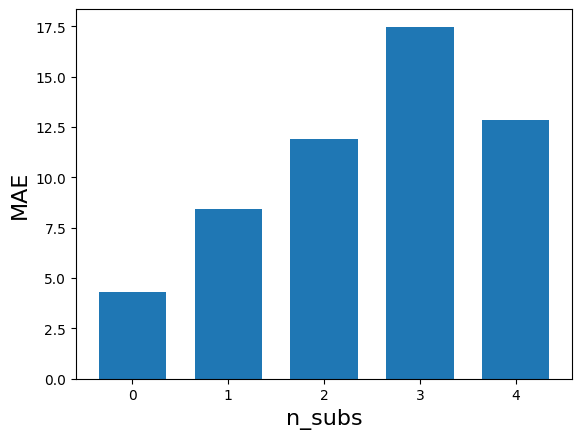

In [38]:
# Error for different nsubs on Training set

nsubs_train = np.zeros( x_train.shape[0] )
#print(x_train[0,:])

# compute number of substitutes for each data train
for i in range(len(nsubs_train)):

    # for each data, check if first input of every position is an hydrogen
    nsubs_i = 0
    for j in range(n_pos):
        if( x_train[i,j*n_atom_types]==0.0 ): # no hydrogen, hence there is a different substitute
            nsubs_i = nsubs_i+1
    nsubs_train[i] = nsubs_i
#print(nsubs_train)

error0 = []
error1 = []
error2 = []
error3 = []
error4 = []
num_subs = np.zeros(5)
for i in range(len(nsubs_train)):
    error_i = y_pred_train[i] - y_true_train[i]
    if(nsubs_train[i]==0): 
        error0.append(error_i)
        num_subs[0] +=1
    if(nsubs_train[i]==1): 
        error1.append(error_i)
        num_subs[1] +=1
    if(nsubs_train[i]==2): 
        error2.append(error_i)
        num_subs[2] +=1
    if(nsubs_train[i]==3): 
        error3.append(error_i)
        num_subs[3] +=1
    if(nsubs_train[i]==4): 
        error4.append(error_i)
        num_subs[4] +=1

error_nsubs = np.zeros(5)
error_nsubs[0] = np.mean(np.abs(error0))
error_nsubs[1] = np.mean(np.abs(error1))
error_nsubs[2] = np.mean(np.abs(error2))
error_nsubs[3] = np.mean(np.abs(error3))
error_nsubs[4] = np.mean(np.abs(error4))

print(num_subs)
print(error_nsubs)

bin_edges = np.arange(1.5,4.5+1,1)
plt.bar([0,1,2,3,4],error_nsubs[0:], width=0.7)
plt.xlabel("n_subs",fontsize=16)
plt.ylabel("MAE",fontsize=16)
plt.show()

In [20]:
# Invariance test

x1 = dataset_np[127,0:16]
x1_flip = x1.copy()
x1_flip = np.flip(x1)
#print(x1)
#print(x1_reverse)

# one-hot encode

x1_ohe = np.zeros((1,n_features))
x1_flip_ohe = np.zeros((1,n_features))
for j in range(n_pos):
    #atom_id = int(dataset_np[0,j])
    atom_id = int(x1[j])
    x1_ohe[0,j*n_atom_types+atom_id] = 1.0
    atom_id = int(x1_flip[j])
    x1_flip_ohe[0,j*n_atom_types+atom_id] = 1.0

x1_inputs = np.split(x1_ohe,n_pos,axis=1)
y_pred1 = model.predict(x1_inputs)
print(y_pred1[0])

x1_flip_inputs = np.split(x1_flip_ohe,n_pos,axis=1)
y_pred1_flip = model.predict(x1_flip_inputs)
print(y_pred1_flip[0])


1/1 [==============================] - 0s 25ms/step
[-0.45891893]
1/1 [==============================] - 0s 24ms/step
[-0.39761195]
